<a href="https://colab.research.google.com/github/Vishy-A/MachineLearningIntro/blob/main/FinalProject/Pytorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
from google.colab import drive
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from collections import OrderedDict

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/airplane_sat.csv'
airplane = pd.DataFrame(pd.read_csv(file_path))

torch.set_printoptions(edgeitems=2, linewidth=75)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
airplane.isnull().sum()*100/airplane.shape[0]

ID                                        0.0
Gender                                    0.0
Age                                       0.0
Customer Type                             0.0
Type of Travel                            0.0
Class                                     0.0
Flight Distance                           0.0
Departure Delay                           0.0
Arrival Delay                             0.0
Departure and Arrival Time Convenience    0.0
Ease of Online Booking                    0.0
Check-in Service                          0.0
Online Boarding                           0.0
Gate Location                             0.0
On-board Service                          0.0
Seat Comfort                              0.0
Leg Room Service                          0.0
Cleanliness                               0.0
Food and Drink                            0.0
In-flight Service                         0.0
In-flight Wifi Service                    0.0
In-flight Entertainment           

In [ ]:
airplane.head()

,ID,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,3,Male,41,Returning,Business,Business,853,0,0,4,...,3,5,3,5,5,3,4,3,3,Satisfied
1,4,Male,50,Returning,Business,Business,1905,0,0,2,...,5,5,5,4,4,5,2,5,5,Satisfied
2,6,Male,43,Returning,Business,Business,3788,0,0,4,...,4,4,4,3,3,4,4,4,4,Satisfied
3,7,Male,43,Returning,Business,Business,1963,0,0,3,...,5,5,5,4,5,5,3,5,5,Satisfied
4,9,Male,50,Returning,Business,Business,2607,0,0,1,...,4,3,4,3,3,4,4,4,4,Neutral or Dissatisfied


In [ ]:
airplane.pop('ID')

varstrings = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Satisfaction']


def binarymap(inp):
  return inp.map({'Male' : 1, 'Female' : 0, 'First-time' : 0, 'Returning' : 1, 'Business' : 0,
                  'Personal' : 1, 'Economy' : 1, 'Economy Plus' : 2, 'Neutral or Dissatisfied' : 0, 'Satisfied' : 1})

airplane[varstrings] = airplane[varstrings].apply(binarymap)

airplane.head()

,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,1,41,1,0,0,853,0,0,4,4,...,3,5,3,5,5,3,4,3,3,1
1,1,50,1,0,0,1905,0,0,2,2,...,5,5,5,4,4,5,2,5,5,1
2,1,43,1,0,0,3788,0,0,4,4,...,4,4,4,3,3,4,4,4,4,1
3,1,43,1,0,0,1963,0,0,3,3,...,5,5,5,4,5,5,3,5,5,1
4,1,50,1,0,0,2607,0,0,1,1,...,4,3,4,3,3,4,4,4,4,0


In [ ]:
y = airplane.pop('Satisfaction')
x = airplane.values

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [ ]:
x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

x.size(), y.size()

(torch.Size([129488, 22]), torch.Size([129488]))

In [ ]:
n_samples = x.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

x_train = x[train_indices]
y_train = y[train_indices]

x_test = x[val_indices]
y_test = y[val_indices]

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, x_train, x_test, y_train, y_test):
  accuracy = 0
  total = 0
  correct = 0
  y_pred = []
  y_true = []

  for epoch in range(1, n_epochs + 1):
    t_p_train = model(x_train)
    loss_train = loss_fn(t_p_train, y_train)

    t_p_test = model(x_test)
    loss_val = loss_fn(t_p_test, y_test)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch % 100 == 0 :
      print(f"Epoch: {epoch}, Training loss: {loss_train.item():.4f}," f" Validation loss: {loss_val.item():.4f}")

  pred = (torch.max(torch.exp(t_p_test), 1)[1]).data.numpy()
  y_pred.extend(pred)
  y_true.extend(y_test)

  cf_matrix = confusion_matrix(y_true, y_pred)

  accuracy = metrics.accuracy_score(y_true, y_pred)
  precision = metrics.precision_score(y_true, y_pred)
  recall = metrics.recall_score(y_true, y_pred)
  F1 = (2*precision*recall)/(precision+recall)
  print('\n\nAccuracy = ', accuracy)
  print('Precision = ', precision)
  print('Recall = ', recall)
  print('F1 Score = ', F1, '\n\n')

  # Print Confusion Matrix
  class_names = ['Satisfied','Neutral/Not Satisfied']
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap='YlGnBu', fmt='g')
  ax.xaxis.set_label_position('top')
  plt.tight_layout()
  plt.title('Confusion Matrix', y=1.1)
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')

In [ ]:
neuron_count = 44

seq_model = nn.Sequential(
    nn.Linear(22, neuron_count),
    nn.Tanh(),
    nn.Linear(neuron_count, 2),
)

seq_model

Sequential(
  (0): Linear(in_features=22, out_features=44, bias=True)
  (1): Tanh()
  (2): Linear(in_features=44, out_features=2, bias=True)
)

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

Epoch: 100, Training loss: 0.3326, Validation loss: 0.3290
Epoch: 200, Training loss: 0.3206, Validation loss: 0.3165
Epoch: 300, Training loss: 0.3103, Validation loss: 0.3062
Epoch: 400, Training loss: 0.2989, Validation loss: 0.2947
Epoch: 500, Training loss: 0.2871, Validation loss: 0.2827
Epoch: 600, Training loss: 0.2749, Validation loss: 0.2704
Epoch: 700, Training loss: 0.2627, Validation loss: 0.2580
Epoch: 800, Training loss: 0.2507, Validation loss: 0.2459
Epoch: 900, Training loss: 0.2394, Validation loss: 0.2345
Epoch: 1000, Training loss: 0.2294, Validation loss: 0.2245


Accuracy =  0.9145460864192764
Precision =  0.9206232137918319
Recall =  0.8807549832421944
F1 Score =  0.9002479152580573 




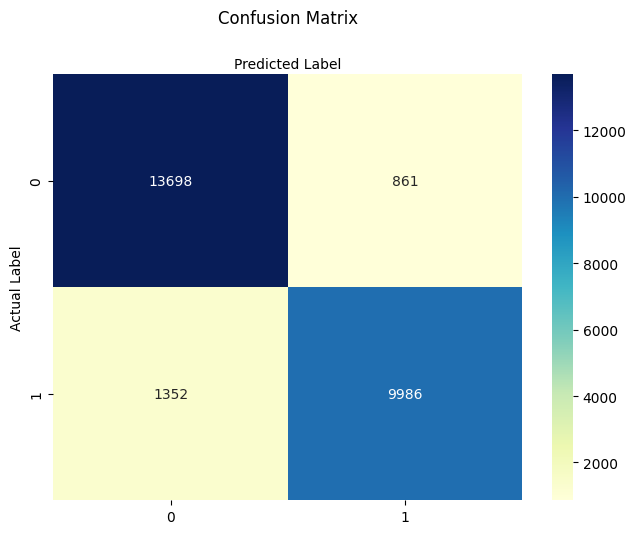

In [ ]:
training_loop(
    n_epochs = 1000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = loss_fn,
    x_train = x_train,
    x_test = x_test,
    y_train = y_train.to(torch.long),
    y_test = y_test.to(torch.long)
    )